In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv('tracks_features.csv')
df = df[df['year'] >= 1922]
df.head()

,id,name,album,album_id,artists,artist_ids,track_number,disc_number,explicit,danceability,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,year,release_date
0,7lmeHLHBe4nmXzuXc0HDjk,Testify,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],1,1,False,0.470,...,0.0727,0.02610,0.000011,0.3560,0.503,117.906,210133,4.0,1999,1999-11-02
1,1wsRitfRRtWyEapl0q22o8,Guerrilla Radio,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],2,1,True,0.599,...,0.1880,0.01290,0.000071,0.1550,0.489,103.680,206200,4.0,1999,1999-11-02
2,1hR0fIFK2qRG3f3RF70pb7,Calm Like a Bomb,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],3,1,False,0.315,...,0.4830,0.02340,0.000002,0.1220,0.370,149.749,298893,4.0,1999,1999-11-02
3,2lbASgTSoDO7MTuLAXlTW0,Mic Check,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],4,1,True,0.440,...,0.2370,0.16300,0.000004,0.1210,0.574,96.752,213640,4.0,1999,1999-11-02
4,1MQTmpYOZ6fcMQc56Hdo7T,Sleep Now In the Fire,The Battle Of Los Angeles,2eia0myWFgoHuttJytCxgX,['Rage Against The Machine'],['2d0hyoQ5ynDBnkvAbJKORj'],5,1,False,0.426,...,0.0701,0.00162,0.105000,0.0789,0.539,127.059,205600,4.0,1999,1999-11-02


In [3]:
def obter_decada(linha):
    ano = str(linha['year'])
    return int(ano[:3] + "0")

df['decade'] = df.apply (lambda x: obter_decada(x), axis=1)

In [4]:
df = df[df['decade'] != "00"]
df.groupby('decade').size()

decade
1920       436
1930       453
1940       653
1950      3159
1960      8784
1970     17183
1980     28595
1990    153049
2000    423753
2010    498089
2020     69726
dtype: int64

## 

In [5]:
# df_1980_a_2010 = df[(df['decade'] >= 1980) & (df['decade'] < 2020)]

df_1980 = df[df['decade'] == 1980].sample(n=1000)
df_1990 = df[df['decade'] == 1990].sample(n=1000)
df_2000 = df[df['decade'] == 2000].sample(n=1000)
df_2010 = df[df['decade'] == 2010].sample(n=1000)

df_1980_a_2010 = pd.concat([df_1980, df_1990, df_2000, df_2010], ignore_index=True, sort=False)

df_1980_a_2010.groupby('decade').size()

decade
1980    1000
1990    1000
2000    1000
2010    1000
dtype: int64

## Dividindo o dataset em bases de teste e treino 

In [6]:
atributos = ['danceability', 'energy', 'key', 'loudness', 'mode', 
        'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
        'valence', 'tempo', 'duration_ms', 'time_signature']

X = df_1980_a_2010[atributos]
y = pd.factorize(df_1980_a_2010['decade'])[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [7]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

## Encontrando os melhores parâmetros

In [8]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 1000, stop = 5000, num = 15)], # quantidade de árvores
               'max_depth': [int(x) for x in np.linspace(10, 210, num = 11)], # número máximo de níveis
              } 

In [9]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions=random_grid, 
                               n_iter = 100, 
                               cv=3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs=-1
                              )

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 30, 50, 70, 90, 110,
                                                      130, 150, 170, 190, 210],
                                        'n_estimators': [1000, 1285, 1571, 1857,
                                                         2142, 2428, 2714, 3000,
                                                         3285, 3571, 3857, 4142,
                                                         4428, 4714, 5000]},
                   random_state=42, verbose=2)

### 

In [10]:
rfc = RandomForestClassifier(n_estimators=rf_random.best_params_['n_estimators'], max_depth=rf_random.best_params_['max_depth'])

rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=190, n_estimators=3571)

In [11]:
y_pred = rfc.predict(X_test)

print("accuracy_score:",metrics.accuracy_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred, average='weighted'))

accuracy_score: 0.35333333333333333
f1_score: 0.3516166227967891


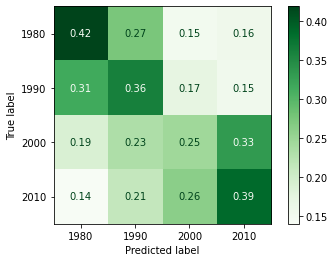

In [12]:
disp = plot_confusion_matrix(rfc, X_test, y_test,
                             display_labels=[1980, 1990, 2000, 2010],
                             cmap=plt.cm.Greens,
                             normalize='true')

plt.show()

In [13]:
atributos_importancia = pd.Series(rfc.feature_importances_,index=atributos).sort_values(ascending=False)
atributos_importancia

loudness            0.118502
energy              0.093736
valence             0.093448
acousticness        0.091422
duration_ms         0.090025
speechiness         0.087870
liveness            0.087510
danceability        0.086947
tempo               0.086890
instrumentalness    0.078877
key                 0.055047
mode                0.015405
time_signature      0.014320
dtype: float64

<AxesSubplot:>

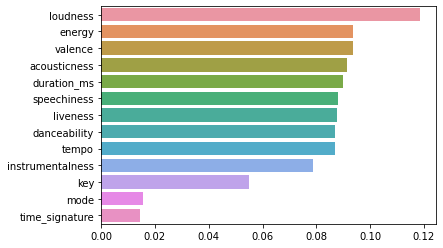

In [14]:
sns.barplot(x=atributos_importancia, y=atributos_importancia.index)